# Radially Constrained Clustering 
The Radially Constrained Clustering (RCC) (Cannon, 2005) is used to define the meteorological seasons in a climate dataset.
The RCC divides a time-series of data into a set of time contiguous clusters, that are the seasons.

RCC can be used in XSeas in two version:
- As a stand alone algorithm (**RCC**)
- Parallelized in xarray (**XRCC**)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import dask
import geopandas as gpd

from xseas import XRCC, RCC
from xseas.utils import day_of_year_to_date

import warnings 
warnings.filterwarnings("ignore")

## Clustering a sinthetic time-series

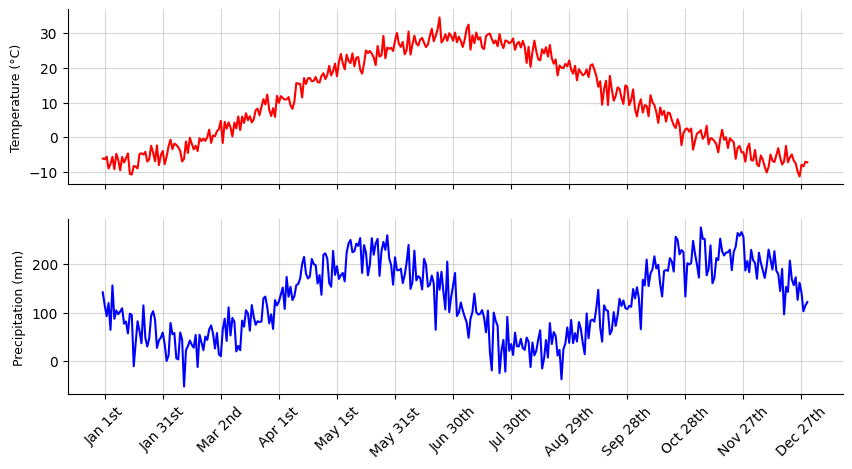

In [2]:
# Create a random time series of temperature data as sinusoidal function with noise
arr_temperature = (0.6 + np.cos(np.linspace(-np.pi, np.pi, 365))) * 18 + np.random.normal(0, 2, 365)

# Create a random time series of precipitation data as sinusoidal function with noise
arr_precipitation = (1 + np.sin(np.linspace(-1*np.pi, 3*np.pi, 365))) * 100 + (np.random.normal(0, 30, 365) + 30)


# Plot the temperature and precipitation data
fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
ax[0].plot(arr_temperature, label='Temperature', color='red')
ax[0].set_ylabel('Temperature (°C)', fontsize=9)
ax[1].plot(arr_precipitation, label='Precipitation', color='blue')
ax[1].set_ylabel('Precipitation (mm)', fontsize=9)

lev = np.arange(1,365.,30).tolist()

for a in ax:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.grid(alpha=0.5)
    a.set_xticks(lev, labels=[day_of_year_to_date(x) for x in lev], rotation=45)

In [3]:
# Merging the array into a single array
arr = np.array([arr_temperature, arr_precipitation]).T

# Normalize the array 
norm_arr = (arr - arr.mean(axis=0)) / arr.std(axis=0)

# The array to be used in the RCC must have the shape (n_samples, n_features)
norm_arr.shape

(365, 2)

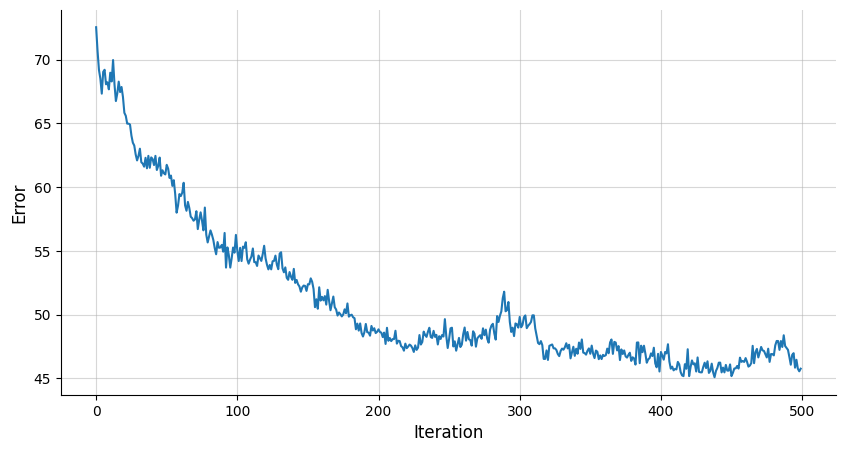

In [4]:
# Defining the RCC model
model = RCC( data_to_cluster = norm_arr,
             n_seas = 4,
             n_iter = 500, 
             min_len= 20, 
             learning_rate= 1,
             starting_bp = [0, 80, 150, 300])

# Fit the model
model.fit()

# Plot the learning curve of the model
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(model.error_history)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Error', fontsize=12)
ax.grid(alpha=0.5)

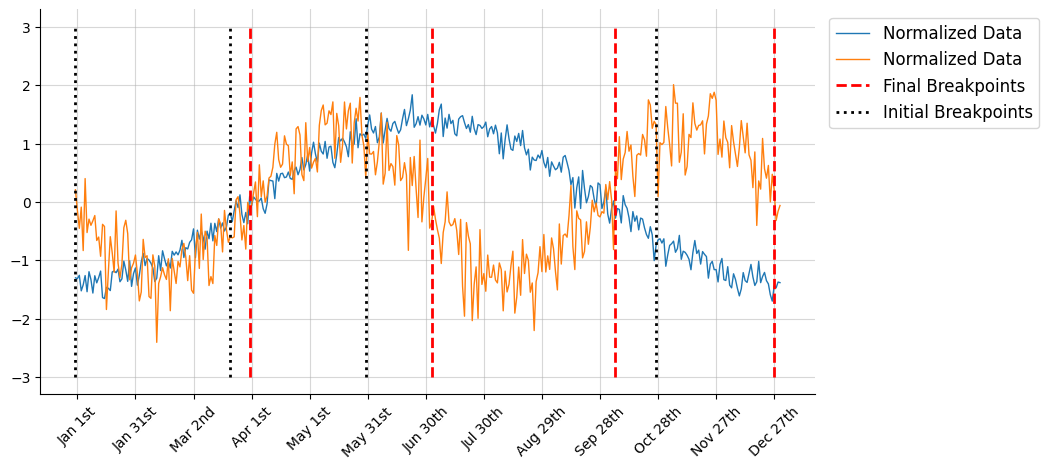

In [5]:
# Plotting the results 
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(norm_arr, lw=1, label='Normalized Data')
ax.vlines(model.breakpoints, ymin=-3, ymax=3, color='red', linestyle='--', lw=2, label = 'Final Breakpoints')
ax.vlines(model.breakpoint_history[0], ymin=-3, ymax=3, color='k', linestyle=':', lw=2, label = 'Initial Breakpoints')

ax.legend(loc='upper right', fontsize=12, bbox_to_anchor=(1.3, 1))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(alpha=0.5)

lev = np.arange(1,365.,30).tolist();
ax.set_xticks(lev, labels=[day_of_year_to_date(x) for x in lev], rotation=45);

## Clustering xarray climate data

In [ ]:
# Loading sample data
dataset_t2m = xr.open_mfdataset('sample_data/INDIA_t2m_1980_1985.nc')['2t']
dataset_tp = xr.open_mfdataset('sample_data/INDIA_tp_1980_1985.nc')['tp']

# Uniforming the time
dataset_tp['time'] = dataset_t2m['time']

In [7]:
# Different variables must be specified as a list
datasets = [dataset_t2m, dataset_tp]

# Define the clustering parameters
# CAN TAKE A FEW MINUTES TO RUN
clustering_params = {
        'iters': 200,
        'n_seas': 2,
        'learning_rate': 1,
        'min_len': 30,
        'mode': 'single',
        'starting_bp': [160, 280],
        'weights': [1, 1] 
    }

# Define the model
breakpoints, error_history_da, silhouette_scores_da = XRCC( datasets, **clustering_params)

# Fit with dask
breakpoints, error_history_da  = dask.compute(breakpoints, error_history_da)

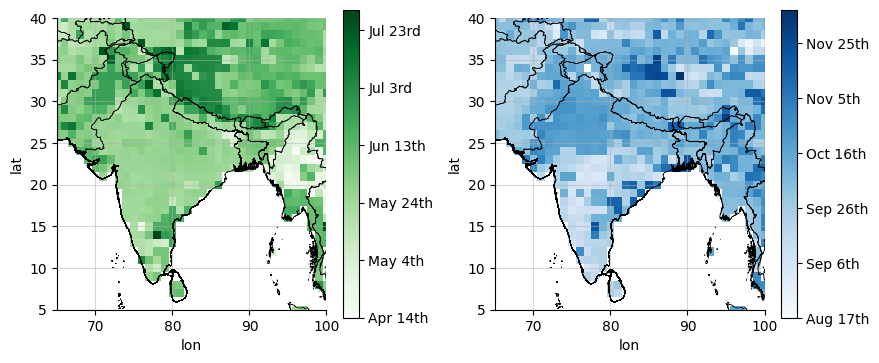

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Load boundaries
india_boundaries = gpd.read_file('sample_data/INDIA_boundary.gpkg')

# Increase spacing between subplots
fig.subplots_adjust(wspace=0.3)

# Plot the breakpoints
breakpoints.isel(cluster=0).plot(ax=ax[0], cmap = 'Greens')
breakpoints.isel(cluster=1).plot(ax = ax[1], cmap = 'Blues')

for a in ax:

    # Plot the boundaries
    india_boundaries.boundary.plot(ax=a, color='black', lw=0.5)

    # Grid settings
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.grid(alpha=0.5)

    # Cbar settings
    cbar = a.collections[0].colorbar
    min_val = cbar.vmin
    max_val = cbar.vmax
    cbar.set_ticks(np.arange(min_val, max_val, 20))
    cbar.set_ticklabels([day_of_year_to_date(x) for x in np.arange(float(min_val), float(max_val), 20)], fontsize=10)

    # Set title
    a.set_title('')

    # Set limits
    a.set_xlim(65, 100)
    a.set_ylim(5, 40)